# Introduction
This document explains the step involved in Building a suitable model for the Propensify  dataset. 

## Data description

| Type            | Name           | Description                                                                 |
|-----------------|----------------|-----------------------------------------------------------------------------|
| Input Variables | custAge         | The age of the customer (in years)                                          |
| Input Variables | profession      | Type of job                                                                 |
| Input Variables | marital         | Marital status                                                              |
| Input Variables | schooling       | Education level                                                             |
| Input Variables | default         | Has a previous defaulted account?                                           |
| Input Variables | housing         | Has a housing loan?                                                         |
| Input Variables | loan            | Has a personal loan?                                                        |
| Input Variables | contact         | Preferred contact type                                                      |
| Input Variables | month           | Last contact month                                                          |
| Input Variables | day_of_week     | Last contact day of the week                                                |
| Input Variables | campaign        | Number of times the customer was contacted                                  |
| Input Variables | pdays           | Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) |
| Input Variables | previous        | Number of contacts performed before this campaign and for this client       |
| Input Variables | poutcome        | Outcome of the previous marketing campaign                                  |
| Input Variables | emp.var.rate    | Employment variation rate - quarterly indicator                             |
| Input Variables | cons.price.idx  | Consumer price index - monthly indicator                                    |
| Input Variables | cons.conf.idx   | Consumer confidence index - monthly indicator                               |
| Input Variables | euribor3m       | Euribor 3 month rate - daily indicator                                      |
| Input Variables | nr.employed     | Number of employees - quarterly indicator                                   |
| Input Variables | pmonths         | Number of months that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) |
| Input Variables | pastEmail       | Number of previous emails sent to this client                               |
| Target Variables| responded       | Did the customer respond to the marketing campaign and purchase a policy?   |


**Summary** 

This dataset combines personal characteristics of the customers (like age, profession, loans), interaction history (like number of contacts, outcomes of previous campaigns), and economic indicators (like employment rate, consumer confidence) to model customer behavior. The ultimate goal is to predict the target variable responded, which indicates whether a customer will respond positively to the marketing campaign.

--------------------------------------------

**Import the required libraries**

In [550]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Data import and EDA

In [551]:
#load historical dataset
df = pd.read_excel(r"D:\upgrade_pracctice\Major Capstone Project\propensify capstone upgrad\data\Propensify\train.xlsx")
df.shape

(8240, 24)

In [552]:
df.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded,profit,id
0,34.0,admin.,single,university.degree,no,no,yes,cellular,apr,wed,...,-1.8,93.075,-47.1,1.498,5099.1,999.0,0.0,no,NaN,1.0
1,31.0,services,single,high.school,no,no,no,cellular,jul,thu,...,1.4,93.918,-42.7,4.968,5228.1,999.0,0.0,no,NaN,2.0
2,NaN,admin.,single,high.school,no,no,no,telephone,jun,NaN,...,1.4,94.465,-41.8,4.961,5228.1,999.0,0.0,no,NaN,3.0
3,52.0,admin.,divorced,university.degree,unknown,yes,no,cellular,jul,tue,...,1.4,93.918,-42.7,4.962,5228.1,999.0,0.0,no,NaN,4.0
4,39.0,blue-collar,single,NaN,unknown,yes,no,cellular,jul,tue,...,1.4,93.918,-42.7,4.961,5228.1,999.0,0.0,no,NaN,5.0


In [553]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8240 entries, 0 to 8239
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   custAge         6224 non-null   float64
 1   profession      8238 non-null   object 
 2   marital         8238 non-null   object 
 3   schooling       5832 non-null   object 
 4   default         8238 non-null   object 
 5   housing         8238 non-null   object 
 6   loan            8238 non-null   object 
 7   contact         8238 non-null   object 
 8   month           8238 non-null   object 
 9   day_of_week     7451 non-null   object 
 10  campaign        8238 non-null   float64
 11  pdays           8238 non-null   float64
 12  previous        8238 non-null   float64
 13  poutcome        8238 non-null   object 
 14  emp.var.rate    8238 non-null   float64
 15  cons.price.idx  8238 non-null   float64
 16  cons.conf.idx   8238 non-null   float64
 17  euribor3m       8238 non-null   f

Check if there are any unnecessary columns

In [554]:
df.columns

Index(['custAge', 'profession', 'marital', 'schooling', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail',
       'responded', 'profit', 'id'],
      dtype='object')

In [555]:
# Dropping unnecessary columns
df = df.drop(['profit', 'id'], axis=1)

**Target distribution**

In [556]:
# Calculate Percentage of target
round(df['responded'].value_counts()/ len(df) * 100, 3)


responded
no     88.714
yes    11.262
Name: count, dtype: float64

The data is highly imbalanced, with about 88% of customers not responding to the marketing campaign, while only 11% did. It's important to address this imbalance in the target variable before building the model.

-------------------------------------------------------------------------------------------------------------------------------

# Treating Missing Values

Check if there are any missing values in the data

In [557]:
missing_values = df.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
custAge           2016
profession           2
marital              2
schooling         2408
default              2
housing              2
loan                 2
contact              2
month                2
day_of_week        789
campaign             2
pdays                2
previous             2
poutcome             2
emp.var.rate         2
cons.price.idx       2
cons.conf.idx        2
euribor3m            2
nr.employed          2
pmonths              2
pastEmail            2
responded            2
dtype: int64


Age, day of the week, and schooling have missing values, making up about 25% of the dataset. These variables are crucial for predicting responses to the marketing campaign. Age affects insurance needs across different life stages, day of the week impacts availability (weekends vs weekdays), and schooling reflects education levels, which can influence insurance decisions. Dropping these variables isn’t ideal, so missing values will be imputed using appropriate techniques to retain their importance in the model.

**1. Imputing missing schooling values:**

Education significantly influences the type of employment individuals pursue. This study examines the relationship between education levels and the corresponding professions to evaluate the education-employment match hypothesis. In light of this, any missing education data is imputed based on the individual’s profession.

In [558]:
#Feature engineering for schooling
schooling_category = {
    'basic.4y' : 'basic',
    'basic.6y' : 'basic',
    'basic.9y' : 'basic',
    'high.school': 'high.school',
    'illiterate':'illiterate',
    'professional.course': 'professional.course',
    'university.degree':'university.degree',
    'unknown':'unknown',
}

df['schooling'] = df['schooling'].replace(schooling_category)

# Imputation of missing values in education based on profession

mode_schooling = df.groupby('profession')['schooling'].agg(lambda x: x.mode()[0]).rename('most_common_schooling').reset_index()
mode_schooling


,profession,most_common_schooling
0,admin.,university.degree
1,blue-collar,basic
2,entrepreneur,university.degree
3,housemaid,basic
4,management,university.degree
5,retired,basic
6,self-employed,university.degree
7,services,high.school
8,student,high.school
9,technician,professional.course


In [559]:
imputation_mapping = {'admin.': 'university.degree',
 'blue-collar': 'basic',
 'entrepreneur': 'university.degree',
 'housemaid': 'basic',
 'management': 'university.degree',
 'retired': 'basic',
 'self-employed': 'university.degree',
 'services': 'high.school',
 'technician': 'professional.course',
 }

df['schooling'] = df['schooling'].combine_first(df['profession'].map(imputation_mapping))

**2. Treating missing age values**

An individual's age can significantly affect their employment status. For instance, students are typically younger than retired individuals, while the ages of working individuals generally fall between these two groups. To address this, age values are imputed based on the individual’s  profession.

In [560]:
# Calculate median age for each profession
median_age = df.groupby('profession')['custAge'].median().rename('mean_age').reset_index()

# Create a mapping from profession to mean age
median_age_dict = median_age.set_index('profession')['mean_age'].to_dict()

# Fill missing age values based on profession
df['custAge']  = df['custAge'].fillna(df['profession'].map(median_age_dict))


**3. Imputing day of week :**

   The day of the week distribution plot indicates that the marketing campaign is evenly distributed across all days. Therefore, missing values for the day of the week will be filled using a random selection method

In [561]:
day_values = df['day_of_week'].value_counts()
print(day_values)

day_of_week
mon    1598
thu    1533
tue    1478
wed    1473
fri    1369
Name: count, dtype: int64


In [562]:
# list unique days of the week
unique_days = df['day_of_week'].dropna().unique()

# Generate random selections for missing values
num_missing = df['day_of_week'].isnull().sum()
random_days = np.random.choice(unique_days, size=num_missing)

#  Fill missing values with the randomly selected days
df.loc[df['day_of_week'].isnull(), 'day_of_week'] = random_days

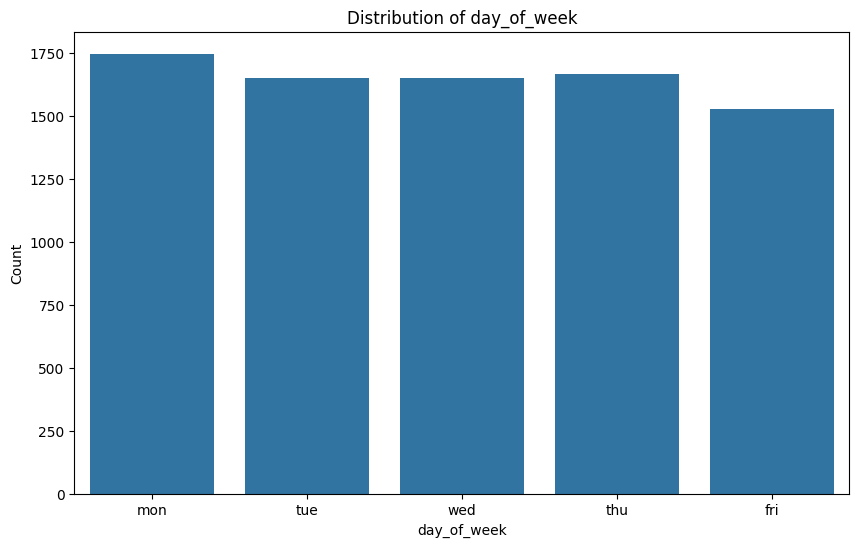

In [563]:
#day of week new distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=df, order=['mon', 'tue', 'wed', 'thu', 'fri'])
plt.title('Distribution of day_of_week')
plt.ylabel('Count')
plt.show()

**Dropping the remaining missing values**

In [564]:
missing_values = df.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
custAge             2
profession          2
marital             2
schooling         135
default             2
housing             2
loan                2
contact             2
month               2
day_of_week         0
campaign            2
pdays               2
previous            2
poutcome            2
emp.var.rate        2
cons.price.idx      2
cons.conf.idx       2
euribor3m           2
nr.employed         2
pmonths             2
pastEmail           2
responded           2
dtype: int64


In [565]:
#Now, dropping remaining missing values
df = df.dropna()

In [566]:
missing_values = df.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
custAge           0
profession        0
marital           0
schooling         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
pmonths           0
pastEmail         0
responded         0
dtype: int64


In [567]:
df.shape

(8105, 22)

-------------------------------------------------------------------------------------------------------------------------------

# Feature Engineering 

Feature engineering of categorical variables:

**1. Profession:**

The profession can be label encoded whether an individual is dependent or working. Dependents insurance is in general 
taken care by the head of the family or by the state. Hence the label encoding is done accordingly.

In [568]:
#1. Profession Distribution

# Display the value counts
profession_counts = df['profession'].value_counts()
print(profession_counts)

profession
admin.           2102
blue-collar      1847
technician       1351
services          792
management        583
retired           337
entrepreneur      314
self-employed     279
housemaid         213
unemployed        125
student           109
unknown            53
Name: count, dtype: int64


In [569]:
# Mapping for label encoding
profession_mapping = {
    'student': 'Dependents', 
    'retired': 'Dependents', 
    'unemployed': 'Unemployed&Unknown', 
    'unknown': 'Unemployed&Unknown', 
    'admin.': 'Working',
    'blue-collar': 'Working',
    'entrepreneur': 'Working',
    'housemaid': 'Working',
    'management': 'Working',
    'self-employed': 'Working',
    'services': 'Working',
    'technician': 'Working'
}

# Apply the mapping to the 'profession' column
df['profession'] = df['profession'].map(profession_mapping)

# Display the updated value counts
profession_counts = df['profession'].value_counts()

# Display the updated DataFrame in a clear format
print(profession_counts)


profession
Working               7481
Dependents             446
Unemployed&Unknown     178
Name: count, dtype: int64


**2. Marital:**

Considering single and divorcee as a single caregory and keeping married and unknown as different categories

In [570]:
#2. Marital distribution

# Display the value counts
profession_counts = df['marital'].value_counts()
print(profession_counts)

marital
married     4900
single      2273
divorced     922
unknown       10
Name: count, dtype: int64


In [571]:
# Mapping for label encoding
marital_mapping = {
    'single': 'Single&Divorced', 
    'divorced': 'Single&Divorced', 
    'married': 'Married', 
    'unknown': 'Unknown'
}

# Apply the mapping to the 'marital' column
df['marital'] = df['marital'].map(marital_mapping)

# Display the updated value counts
marital_counts = df['marital'].value_counts()
print(marital_counts)


marital
Married            4900
Single&Divorced    3195
Unknown              10
Name: count, dtype: int64


**3. Schooling:**

An indiviudual's education can explain whether an indiidual is illiterate, or basic-educated or educated. Label encoding accordingly.

In [572]:
#2. Schooling distribution

# Display the value counts
profession_counts = df['schooling'].value_counts()
print(profession_counts)

schooling
university.degree      2685
basic                  2456
high.school            1579
professional.course    1124
unknown                 260
illiterate                1
Name: count, dtype: int64


In [573]:
# Mapping for label encoding
schooling_mapping = {
    'basic': 'Uneducated&BasicEducation', 
    'high.school': 'Uneducated&BasicEducation', 
    'illiterate': 'Uneducated&BasicEducation', 
    'unknown': 'Unknown',
    'professional.course': 'Educated',
    'university.degree': 'Educated'
}

# Apply the mapping to the 'schooling' column
df['schooling'] = df['schooling'].map(schooling_mapping)

# Display the updated value counts
schooling_counts = df['schooling'].value_counts()
print(schooling_counts)


schooling
Uneducated&BasicEducation    4036
Educated                     3809
Unknown                       260
Name: count, dtype: int64


**4. Month:**

Transforming monthly data into quarterly data helps prevent the creation of an excessive number of dimensions during one-hot encoding.

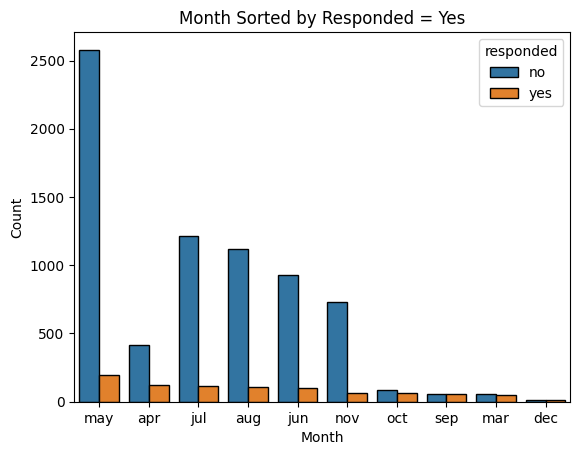

In [574]:
# Monthly distribution of count

# Filter for 'yes' responses, then count occurrences of 'month' and sort by count
df_yes_sorted = df[df['responded'] == 'yes']['month'].value_counts().sort_values(ascending=False)

# Create the bar plot sorted by 'yes' values
sns.countplot(data=df, x='month', hue='responded', order=df_yes_sorted.index, edgecolor='black')
plt.title('Month Sorted by Responded = Yes')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

In [575]:
# Transforming month to quarter in a new column
# Create a dictionary mapping  month names to quarters
month_to_quarter = {
    'jan': 'Q1', 'feb': 'Q1', 'mar': 'Q1',
    'apr': 'Q2', 'may': 'Q2', 'jun': 'Q2',
    'jul': 'Q3', 'aug': 'Q3', 'sep': 'Q3',
    'oct': 'Q4', 'nov': 'Q4', 'dec': 'Q4'
}

# Map the  month names to quarters
df['quarter'] = df['month'].map(month_to_quarter)

# Dropping month column
df = df.drop(columns='month', axis=1)

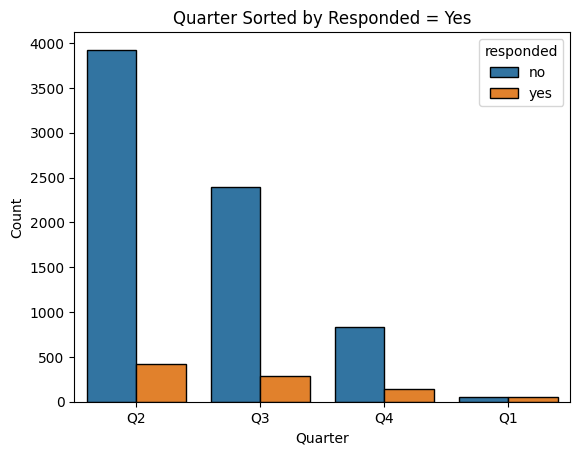

In [576]:
# updated Quarterly distribution of count
# Filter for 'yes' responses, then count occurrences of 'quarter' and sort by count
df_yes_sorted = df[df['responded'] == 'yes']['quarter'].value_counts().sort_values(ascending=False)

# Create the bar plot sorted by 'yes' values in quarters
sns.countplot(data=df, x='quarter', hue='responded', order=df_yes_sorted.index, edgecolor='black')
plt.title('Quarter Sorted by Responded = Yes')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.show()

**5. pdays and pmonths**

In [577]:
# transforming pdays and pmonths into relevant bins
#pdays transformation
conditions = [
    (df['pdays'] == 999),
    (df['pdays'] < 5),
    ((df['pdays'] >= 5) & (df['pdays'] <= 10)),
    (df['pdays'] > 10)
]

choices = ['new visit', 'less than 5 days', '5 to 10 days', 'more than 10 days']

# Create the 'pduration' column based on conditions
df['pdays_bin'] = np.select(conditions, choices, default='unknown')

#pmonths
conditions = [
    (df['pmonths'] == 999),
    (df['pmonths'] <= 0.2),
    (df['pmonths'] > 0.2)
]

choices = ['new visit', 'less than 2 months',  'more than 2 months']

# Create the 'pduration' column based on conditions
df['pmonths_bin'] = np.select(conditions, choices, default='unknown')


6. **Day of week:**

In [578]:
#Label encoding
df['day_of_week'] = df['day_of_week'].map({'mon': 'WeekBeginning', 'tue': 'WeekBeginning','wed':'WeekBeginning',
                                                                      'thu':'WeekEnding','fri':'WeekEnding'})

# Display the updated DataFrame
df['day_of_week'].value_counts()

day_of_week
WeekBeginning    4966
WeekEnding       3139
Name: count, dtype: int64

**7. Default:**

In [579]:
# Yes and Unknown are grouped together and No is kept as a seperate category
#Label encoding
df['default'] = df['default'].map({'no': 'No', 'unknown': 'Yes&Unknown','yes':'Yes&Unknown' })

# Display the updated DataFrame
df['default'].value_counts()

default
No             6504
Yes&Unknown    1601
Name: count, dtype: int64

In [580]:
df.dtypes

custAge           float64
profession         object
marital            object
schooling          object
default            object
housing            object
loan               object
contact            object
day_of_week        object
campaign          float64
pdays             float64
previous          float64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
pmonths           float64
pastEmail         float64
responded          object
quarter            object
pdays_bin          object
pmonths_bin        object
dtype: object

**Leaving rest of the columns unchanged**

----------------------------------------------------------------------------------------------------------------------------

## One hot encoding categoric features

In [581]:
# One hot encoding and normalization for appropriate variables 
# Drop target and unnecessary columns
X = df.drop(['responded', 'pdays','pmonths'], axis=1)
y = df['responded']

# categorical columns
cat_col = X.select_dtypes('object').columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns= cat_col ,drop_first=True)

## Normalizing continuous features 

In [582]:
# Identify continuous columns for normalization
continuous_columns = X.select_dtypes('float').columns

# Extract the continuous columns from X_encoded
X_continuous = X_encoded[continuous_columns]

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the continuous data
X_continuous_normalized = scaler.fit_transform(X_continuous)

# Replace the original continuous columns in X_encoded with the normalized ones
X_encoded[continuous_columns] = X_continuous_normalized



In [583]:
# encoding target variable to [0,1]
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

In [584]:
X_encoded.head()

,custAge,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pastEmail,profession_Unemployed&Unknown,...,poutcome_nonexistent,poutcome_success,quarter_Q2,quarter_Q3,quarter_Q4,pdays_bin_less than 5 days,pdays_bin_more than 10 days,pdays_bin_new visit,pmonths_bin_more than 2 months,pmonths_bin_new visit
0,-0.597795,-0.195319,-0.354742,-1.194204,-0.861075,-1.404311,-1.207010,-0.925255,-0.282944,False,...,True,False,True,False,False,False,False,True,False,True
1,-0.914136,11.982073,-0.354742,0.853874,0.599424,-0.455814,0.788590,0.856730,-0.282944,False,...,True,False,False,True,False,False,False,True,False,True
2,-0.386901,-0.564331,-0.354742,0.853874,1.547102,-0.261803,0.784565,0.856730,-0.282944,False,...,True,False,True,False,False,False,False,True,False,True
3,1.300250,-0.195319,-0.354742,0.853874,0.599424,-0.455814,0.785140,0.856730,-0.282944,False,...,True,False,False,True,False,False,False,True,False,True
4,-0.070560,1.280728,-0.354742,0.853874,0.599424,-0.455814,0.784565,0.856730,-0.282944,False,...,True,False,False,True,False,False,False,True,False,True


In [585]:
X_encoded.shape

(8105, 32)

-------------------------------------------------------------------------------------------------------------------------------

# Choice of sampling:
The data is highly imbalanced, so resampling is necessary. Using only oversampling could create too many synthetic examples, while undersampling might lose important information. Therefore, a mixed sampling method called **SMOTE-NN** is used, which combines both techniques. SMOTE generates synthetic data for the minority class using k-nearest neighbors to balance the dataset.


-------------------------------------------------------------------------------------------------------------------------------

# Metrics and Model Choice:
Due to the highly imbalanced data, machine learning models tend to predict the majority class (in this case, "No" for not responding), leading to high overall accuracy. However, this can be misleading for the business, as failing to identify potential customers ("Yes" for responded) could result in missed revenue opportunities.

Thus, it's crucial to improve the recall of the minority class ("Yes"), as not marketing to potential customers can be costly. While focusing solely on accuracy may result in high numbers (e.g., a Random Forest Classifier achieving 89% accuracy without addressing imbalance), the recall for the minority class could drop as low as 30%. This would cause the company to miss out on potential customers.

At the same time, accuracy must remain high to avoid excessive marketing costs by targeting those unlikely to buy. The project specifies maintaining accuracy above 85%, while this report emphasizes maximizing recall for the minority class without letting accuracy fall below the required threshold.

To strike a balance between accuracy and recall, an **XGBoost Classifier** was chosen for the model. XGBoost (Extreme Gradient Boosting) is a powerful, highly efficient algorithm known for its ability to handle imbalanced datasets, which is crucial for this project. Its advanced handling of gradient boosting helps in improving model precision without overfitting, especially in cases where one class significantly outnumbers the other, as is the case here.

----------------------------------------------------------------------------------------------------------------------------

# Model

In [586]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)


y_train = np.array(y_train)
y_test = np.array(y_test)

# Apply SMOTEENN to the training data
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)


Accuracy: 0.8507
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1457
           1       0.35      0.56      0.43       164

    accuracy                           0.85      1621
   macro avg       0.65      0.72      0.67      1621
weighted avg       0.89      0.85      0.87      1621



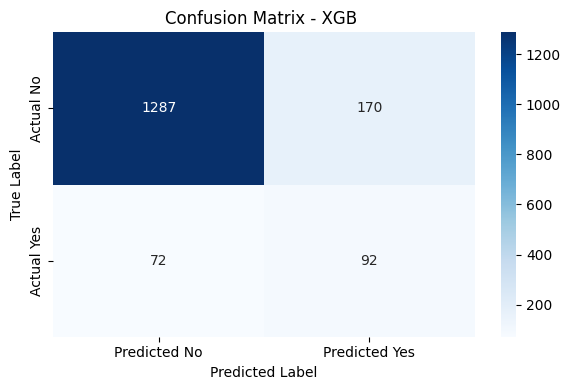

In [587]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)

# Train the classifier
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = xgb_clf.predict(X_test)


# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No', 'Predicted Yes'], 
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix - XGB ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

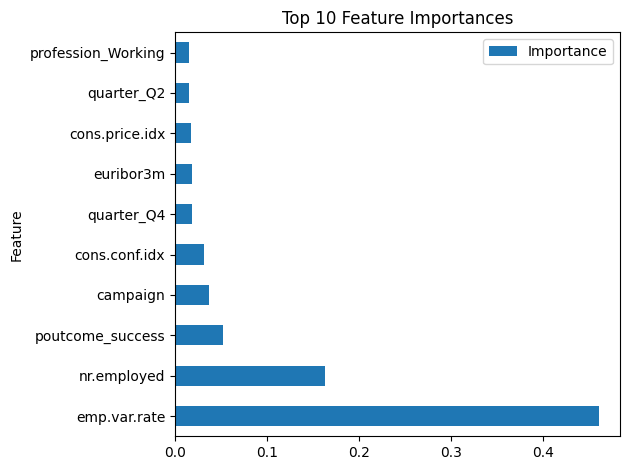

In [588]:
# Get top 10 feature importances
importances = xgb_clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_resampled.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance
feature_importance_df.plot(kind='barh', x='Feature', y='Importance', title='Top 10 Feature Importances')
plt.tight_layout()
plt.show()

# Fine-tuning XGBoost with Regularization

In [589]:

# Define the parameter grid for regularization
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_lambda': [0, 0.5, 1.0],  # L2 regularization
    'max_depth': [3, 5, 7],    
    'gamma': [0, 0.5, 1.0],  
    'n_estimators': [50, 100, 200]  
}


# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=xgb_clf, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           verbose=1, 
                           n_jobs=-1)

# Fit the model with the training data 
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model and parameters
best_xgb = grid_search.best_estimator_
print('Best Regularization Parameters:', grid_search.best_params_)



Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Regularization Parameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'reg_lambda': 0.5}


Accuracy: 0.8476
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1457
           1       0.35      0.57      0.43       164

    accuracy                           0.85      1621
   macro avg       0.65      0.72      0.67      1621
weighted avg       0.89      0.85      0.86      1621



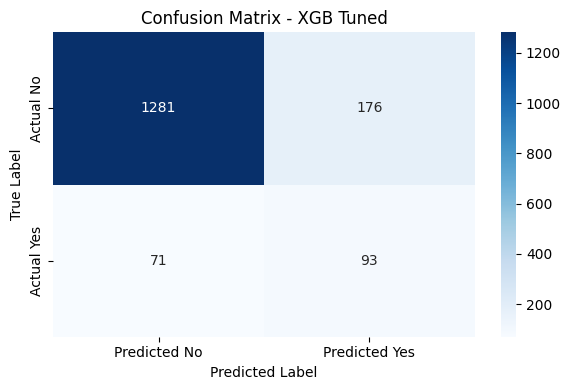

In [590]:
# Prediction by tuned model
y_pred = best_xgb.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No', 'Predicted Yes'], 
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix - XGB Tuned')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Model Utility

The results show that the model maximizes recall for the minority class while maintaining accuracy above 85%, meeting project requirements. This ensures a good balance between accuracy and recall, helping the company control marketing costs while reaching most potential customers. Since hyperparameter tuning resulted in lower accuracy than the default settings, the default model is preferred.

-----------------------------------------------------------------------------------------------------------------------